In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Set machine precision as constant
MACHINE_PRECISION = np.finfo(float).eps


# general scalar projection function for normlization of vectors/wavefunctions
def project(psi1, psi2, x_vec):
    return np.trapz(np.conj(psi1)*psi2, x=x_vec)
def normalize(psi, x_vec):
    return psi/np.sqrt(project(psi, psi, x_vec))

def return_mean_data(filenames):
    """
    This function takes an array of filenames, reads the data from each file,
    and returns the mean x and y data.
    
    Parameters:
    filenames (list): List of file paths to read data from.
    
    Returns:
    tuple: Mean x and y data as numpy arrays.
    """
    no_of_files = len(filenames)
    
    # Calculate mean of the x and y data from all files
    mean_x = np.zeros_like(np.loadtxt(filenames[0])[:, 0])
    mean_y = np.zeros_like(np.loadtxt(filenames[0])[:, 1])

    for filename in filenames:
        data = np.loadtxt(filename)
        x = data[:, 0]
        y = data[:, 1]
        
        mean_x += x
        mean_y += y
            
    # Average the accumulated values
    mean_x /= no_of_files 
    mean_y /= no_of_files 
    
    return mean_x, mean_y
    
def scale_y_data(x,y):
    """Scales the y-data to the range [0, 1] based on the maximum and minimum values of y.
    Args:
        x, y (numpy arrays): The x and y data to be scaled.
    """
    max_y = np.max(y)
    min_y = np.min(y)
        
    y = (y - min_y) / (max_y - min_y)
    return x, y

# traverse through all files in the given filepath array and plot the mean data
def plot_mean_data(filenames, title="DemoTitle", labelname="DemoLabel", normalize_data=False, scale_data = False):
    mean_x, mean_y = return_mean_data(filenames)

    
    
    # normalize the mean_y data
    if normalize_data:
        # Normalize mean_y with respect to mean_x
        mean_y = normalize(mean_y, mean_x)
        
        
    # scale the mean_y data 
    if scale_data:
        mean_x, mean_y = scale_y_data(mean_x, mean_y)
            
        
    # machine_precision = np.finfo(float).eps
    # mean_y =  mean_y + machine_precision


    # Plot the mean data
    # plt.figure(figsize=(10, 6))
    plt.plot(mean_x, mean_y, linestyle='-', label=labelname)
    # Add labels and title  
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity (a.u.)')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    
    

#### Error - filepath issue
Similar to windows, the filepath issues persists and must be recitified in Linux

In [4]:
# mean data for the different materials, plotting only when max SPM is acheived
maxbroadening_air = [Path(rf"\SCG-data-cleaned\air vs BK7\maxpower, AIR, 2350mw{i}.txt") for i in range(14, 35)]
maxbroadening_bk7 = [Path(rf"\SCG-data-cleaned\air vs BK7\maxpower, BK7, 2350mw{i}.txt") for i in range(11, 35)]
maxbroadening_fs = [Path(rf"\SCG-data-cleaned\air vs FS\maxpower, FS , 2350mw{i}.txt") for i in range(1, 20)]

plt.figure(figsize=(10, 7))
normalize = False
scale = True
plot_mean_data(maxbroadening_air, title="", labelname="Air", normalize_data = normalize, scale_data = scale)
plot_mean_data(maxbroadening_bk7, title="", labelname="BK7", normalize_data = normalize, scale_data = scale)
plot_mean_data(maxbroadening_fs, title="", labelname="FS", normalize_data = normalize, scale_data = scale)
plt.xlabel('Wavelength (nm)')
plt.title('Comparison of SCG spectra for Air, BK7, and FS \n Laser power: 2350mW, Normalization: False, Scaling: True')
plt.ylabel('Intensity (a.u.)')  
plt.legend()
# plt.yscale('log')
# plt.ylim(10**-3, 1.25)

# for removal of the noise, we consider only y-scale values above 0.0001

FileNotFoundError: \SCG-data-cleaned\air vs BK7\maxpower, AIR, 2350mw14.txt not found.

<Figure size 1000x700 with 0 Axes>

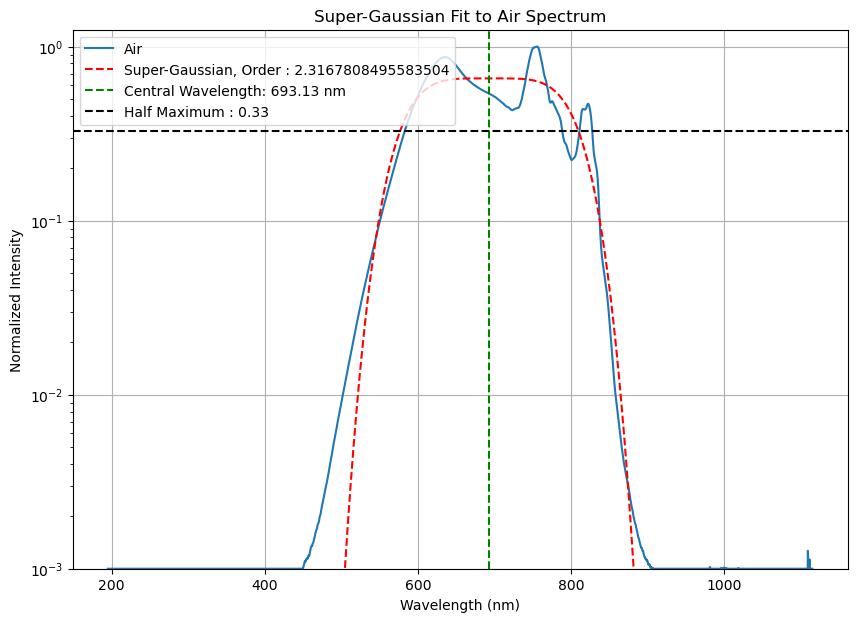

In [ ]:
from scipy.optimize import curve_fit

#  Define super-Gaussian model with absolute exponent
def supergauss(wl, A, lambda0, sigma, n):
    return A * np.exp(-np.abs((wl - lambda0) / sigma)**(2*n))

def fit_supergaussian(x, y, A0, lambda0_0, sigma0, n0):
    """
    Fit a super-Gaussian function to the data.
    Parameters:
    x (array-like): The x data (wavelength).
    y (array-like): The y data (intensity).
    A0 (float): Initial guess for the amplitude.
    lambda0_0 (float): Initial guess for the central wavelength.
    sigma0 (float): Initial guess for the width of the super-Gaussian.
    n0 (float): Initial guess for the exponent of the super-Gaussian.
    
    Returns:
    tuple: Fitted parameters (A, lambda0, sigma, n).
    """
    
    p0 = [A0, lambda0_0, sigma0, n0]
    
    # Define bounds for the parameters
    # Bounds for the parameters:
    # A: [0, inf], lambda0: [min(x), max(x)], sigma: [0, inf], n: [2, 20]
    bounds = ([0, x.min(), 0, 2], [1, x.max(), np.inf, 20])


    # Perform the fit
    popt, pcov = curve_fit(
        supergauss,
        x,
        y,
        p0=p0,
        bounds=bounds,
        maxfev=5000
    )
    
    return popt, pcov



# Super-Gaussian fit to the Air spectrum
x_air, y_air = return_mean_data(maxbroadening_air)
x_air, y_air = scale_y_data(x_air, y_air)

# Remove values below 0.001 from y_air, set them to -4 (log10(0.0001))
# This corresponds to the noise level we want to cut out
y_air = np.where(y_air < 0.001, 0.001, y_air)  # -4 corresponds to log10(0.0001)

# Now we have the x,y data for Air, with noise removed
# We make guessed values for the super-Gaussian parameters (roughly based on the data range seen in the plot)
# Initial guesses and bounds
A0 = 1.0
lambda0_0 = 650 # Initial guess for the central wavelength, roughly in the middle of the range
sigma0 = (x_air.max() - x_air.min()) / 10  # Initial guess for the width, 10% of the range
n0 = 2 # Initial guess for the exponent, starting with a value of 2
p0 = [A0, lambda0_0, sigma0, n0]
bounds = ([0, x_air.min(), 0, 2], [np.inf, x_air.max(), np.inf, 20])

# 5. Perform the fit
popt, pcov = fit_supergaussian(x_air, y_air, A0, lambda0_0, sigma0, n0)
A_fit, lambda0_fit, sigma_fit, n_fit = popt


y_fitted = supergauss(x_air, *popt) + MACHINE_PRECISION # Add machine precision to avoid log(0) issues


plt.figure(figsize=(10, 7))
plt.plot(x_air, y_air, linestyle='-', label="Air")
plt.plot(x_air, y_fitted, linestyle='--', label=f'Super-Gaussian, Order : {n_fit}', color='red')
plt.axvline(lambda0_fit, color='green', linestyle='--', label=f'Central Wavelength: {lambda0_fit:.2f} nm')
plt.axhline(A_fit/2, color='black', linestyle='--', label=f'Half Maximum : {A_fit/2:.2f}')

plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Intensity')
plt.title('Super-Gaussian Fit to Air Spectrum')
plt.legend(loc='upper left')

plt.grid(True)
plt.yscale('log')
plt.ylim(10**-3, 1.25)
plt.show()





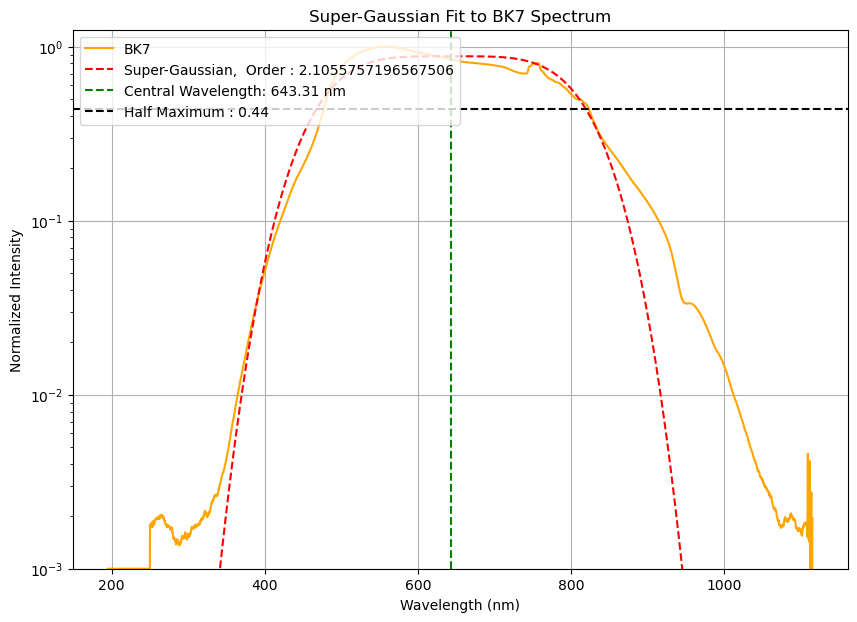

In [ ]:
# Super-Gaussian fit to the BK7 spectrum

x_bk7, y_bk7 = return_mean_data(maxbroadening_bk7)
x_bk7, y_bk7 = scale_y_data(x_bk7, y_bk7)

#
y_bk7 = np.where(y_bk7 < 0.001, 0.001, y_bk7) 

# Initial guesses and bounds
A0 = 1.0
lambda0_0 = 550 # Initial guess for the central wavelength, roughly the peak
sigma0 = (x_bk7.max() - x_bk7.min()) / 10  
n0 = 2 
p0 = [A0, lambda0_0, sigma0, n0]
bounds = ([0, x_bk7.min(), 0, 2], [np.inf, x_bk7.max(), np.inf, 20])

# Perform the fit
popt, pcov = fit_supergaussian(x_bk7, y_bk7, A0, lambda0_0, sigma0, n0)
A_fit, lambda0_fit, sigma_fit, n_fit = popt

y_fitted = supergauss(x_air, *popt) + MACHINE_PRECISION # Add machine precision to avoid log(0) issues

plt.figure(figsize=(10, 7))
plt.plot(x_bk7, y_bk7, linestyle='-', label="BK7", color='orange')
plt.plot(x_bk7, y_fitted, linestyle='--', label=f'Super-Gaussian,  Order : {n_fit}', color='red')
plt.axvline(lambda0_fit, color='green', linestyle='--', label=f'Central Wavelength: {lambda0_fit:.2f} nm')
plt.axhline(A_fit/2, color='black', linestyle='--', label=f'Half Maximum : {A_fit/2:.2f}')

plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Intensity')
plt.title('Super-Gaussian Fit to BK7 Spectrum')
plt.legend(loc = "upper left")
plt.yscale('log')
plt.ylim(10**-3, 1.25)
plt.grid(True)
plt.show()

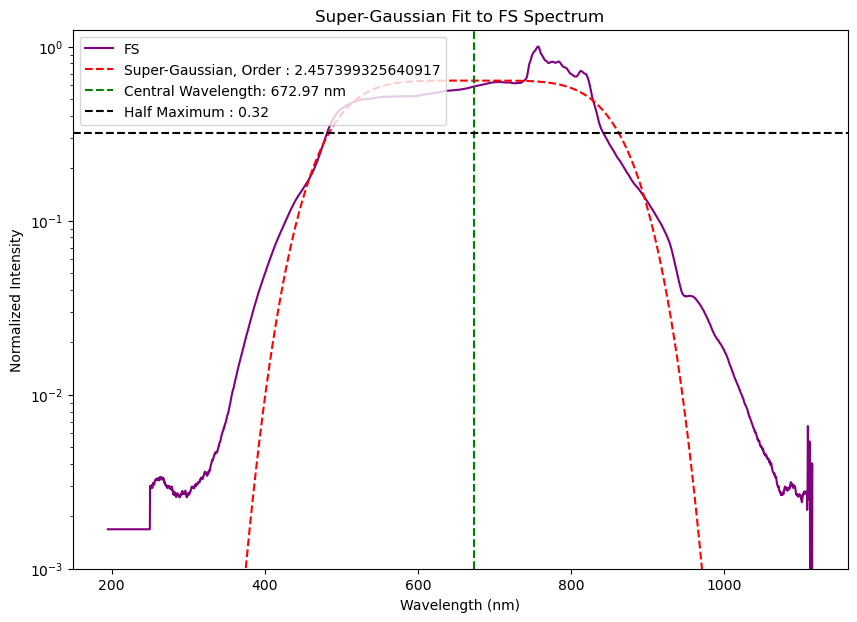

In [ ]:
# Super-Gaussian fit to the FS spectrum

x_fs , y_fs = return_mean_data(maxbroadening_fs)
x_fs, y_fs = scale_y_data(x_fs, y_fs)

y_fs = np.where(y_fs < 0.001, 0.001, y_fs)

# Initial guesses and bounds
A0 = 1.0           
lambda0_0 = 600 
sigma0 = (x_fs.max() - x_fs.min()) / 10
n0 = 2
p0 = [A0, lambda0_0, sigma0, n0]

popt, pcov = fit_supergaussian(x_fs, y_fs, A0, lambda0_0, sigma0, n0)
A_fit, lambda0_fit, sigma_fit, n_fit = popt 

y_fitted = supergauss(x_fs, *popt) + MACHINE_PRECISION  # Add machine precision to avoid log(0) issues

plt.figure(figsize=(10, 7))
plt.plot(x_fs, y_fs, linestyle='-', label="FS", color='purple')
plt.plot(x_fs, y_fitted, linestyle='--', label=f'Super-Gaussian, Order : {n_fit}', color='red')
plt.axvline(lambda0_fit, color='green', linestyle='--', label=f'Central Wavelength: {lambda0_fit:.2f} nm')
plt.axhline(A_fit/2, color='black', linestyle='--', label=f'Half Maximum : {A_fit/2:.2f}')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Intensity')  
plt.title('Super-Gaussian Fit to FS Spectrum')
plt.legend(loc='upper left')
plt.yscale('log')
plt.ylim(10**-3, 1.25)
plt.show()


### Generalized Supergaussian fit code
Test for working, do not change code above.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def supergauss(x, A, x0, sigma, n):
    """
    Super-Gaussian function:
      A * exp(-| (x - x0) / sigma |^n )
    """
    return A * np.exp(-np.abs((x - x0) / sigma)**n)

def fit_supergaussian(x, y):
    """
    Fit a super-Gaussian to arbitrary x, y data.
    Returns a dict with keys: A, center, sigma, n, half_max, FWHM.
    """
    # Normalize y to [0, 1]
    y_norm = (y - np.min(y)) / (np.max(y) - np.min(y))
    # Initial guesses
    A0 = 1.0
    x0_0 = x[np.argmax(y_norm)]
    sigma0 = (np.max(x) - np.min(x)) / 10
    n0 = 4.0
    p0 = [A0, x0_0, sigma0, n0]
    bounds = ([0, np.min(x), 0, 2], [np.inf, np.max(x), np.inf, 20])
    # Perform fit
    popt, _ = curve_fit(supergauss, x, y_norm, p0=p0, bounds=bounds, maxfev=5000)
    A_fit, x0_fit, sigma_fit, n_fit = popt
    # Compute half-max and FWHM
    half_max = A_fit / 2
    FWHM = 2 * sigma_fit * (np.log(2))**(1 / n_fit)
    return {
        'A': A_fit,
        'center': x0_fit,
        'sigma': sigma_fit,
        'n': n_fit,
        'half_max': half_max,
        'FWHM': FWHM
    }

def plot_data_and_fit(title, x, y):
    """
    Plot raw data x,y and super-Gaussian fit.
    Annotates center, FWHM boundaries, and half-max.
    Prints center, half-max, and FWHM.
    """
    results = fit_supergaussian(x, y)
    A_fit = results['A']
    x0 = results['center']
    sigma = results['sigma']
    n = results['n']
    half_max = results['half_max']
    FWHM = results['FWHM']
    # Normalize y for plotting
    y_norm = (y - np.min(y)) / (np.max(y) - np.min(y))
    y_fit = supergauss(x, A_fit, x0, sigma, n)
    left_edge = x0 - FWHM / 2
    right_edge = x0 + FWHM / 2

    plt.figure(figsize=(8, 5))
    plt.plot(x, y_norm, label='Normalized data')
    plt.plot(x, y_fit, linestyle='--', label='Super-Gaussian fit')
    plt.axvline(x0, color='gray', linestyle=':', linewidth=1.5, label=f'Center = {x0:.1f} nm')
    plt.axvline(left_edge, color='red', linestyle='-.', linewidth=1.5)
    plt.axvline(right_edge, color='red', linestyle='-.', linewidth=1.5, label=f'FWHM = {FWHM:.1f} nm')
    plt.axhline(half_max, color='blue', linestyle=':', linewidth=1.5, label=f'Half max = {half_max:.2f}')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Normalized Intensity')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Print results
    print(f"Center = {x0:.1f} nm")
    print(f"Half max = {half_max:.2f}")
    print(f"FWHM = {FWHM:.1f} nm")

# Demonstrate functioning with air data




plot_data_and_fit('Super-Gaussian Fit on Uploaded Data', wavelength, intensity)
